In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis

In [32]:
# Read depression_cleaned.csv into DataFrame.
df = pd.read_csv("depression_cleaned.csv")

df.head(5)

,id,tweet,label
0,637894677824413696,diagnose anxiety depression moment reflect far...,1
1,637890384576778240,sunday need break planning spend little possib...,1
2,637749345908051968,awake tire need sleep brain idea,1
3,637696421077123073,retro bear perfect gift great beginner stitch ...,1
4,637696327485366272,hard whether pack list life easier reinforce n...,1


### Handle Missing Data

##### There was no missing data found in the data cleaning process performed by data_cleaner.py. However, after saving the cleaned data to CSV format, missing values are present.

In [33]:
print(df.isnull().sum())

id         0
tweet    409
label      0
dtype: int64


In [34]:
# Fill missing values with the most frequent value in the column.
df['tweet'] = df['tweet'].fillna(df['tweet'].mode()[0])

In [35]:
print(df.isnull().sum())

id       0
tweet    0
label    0
dtype: int64


## Basic Dataset Statistics

In [36]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (19881, 3)


In [37]:
print(df['label'].value_counts())

label
1    9942
0    9939
Name: count, dtype: int64


## Basic Tweet Statistics

In [38]:
# Get the average number of words in the tweets by splitting on whitespace.
df['word_count'] = df['tweet'].apply(lambda x: len(x.split()))

print(f"Average word count: {df['word_count'].mean()}")

Average word count: 4.922840903375082


In [39]:
# Get the average number of characters in the tweets.
df['tweet_length'] = df['tweet'].apply(len)

print(f"Average tweet length: {df['tweet_length'].mean()}")

Average tweet length: 33.3669835521352


# Feature Extraction

## Convert Text Data into Numerical Features

### CountVectorizer

##### CountVectorizer is a feature extraction method that converts the tweets into a matrix of token counts. This numerical representation is necessary for LDA, which can't directly process raw text. LDA specifically works well with CountVectorizer because it's designed to model word counts rather than normalised values.

##### Words appearing in 95% or more of the tweets will be ignored, filtering out common words.
##### Words appearning in fewer than 2 tweets will be ignored, filtering out rare words.
##### The vocabulary size is limited to the top 5,000 most frequently occurring words.

In [40]:
# Use CountVectorizer for LDA.
count_vectoriser = CountVectorizer(max_df=0.95, min_df=2, max_features=5000)

##### The 'tweet' column is  transformed into a sparse matrix of word counts. The vocabulary is learnt from the text and the text is transformed into a word frequency matrix.

In [41]:
# Apply CountVectorizer to the 'tweet' column.
count_data = count_vectoriser.fit_transform(df['tweet'])

print(f"CountVectorizer shape: {count_data.shape}")

CountVectorizer shape: (19881, 5000)


##### There are 5,000 unique tokens in the vocabulary.

# Topic Modelling

### LDA (Latent Dirichlet Allocation)

##### LDA (Latent Dirichlet Allocation) the topic modelling technique used. It identifies patterns of co-occuring words in the tweets and groups them into coherent topics. 

In [42]:
# Create and fit the LDA model.
n_topics = 10

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    learning_method='batch',
    max_iter=25,
    learning_offset=50.
)

lda.fit(count_data)

# Get topics for each tweet.
lda_output = lda.transform(count_data)

# Print the keywords for each topic.
feature_names = count_vectoriser.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    # Print the top 10 keywords for each topic.
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

Topic 1:
good never god best always friend video yall feel everyone
Topic 2:
people think trump business child game show wrong care lose
Topic 3:
shit girl migraine headache hell woman stress ill cause worth
Topic 4:
need feel sleep person doe man home mean team start
Topic 5:
depression treatment overcome help work post nanny therapy daily play
Topic 6:
trump fuck putin positive hard president think believe second tonight
Topic 7:
love guy people america use want problem put world eat
Topic 8:
want life health ask mental sorry hate next ive top
Topic 9:
someone miss die night live hour bad cut addiction away
Topic 10:
happy great change hope christmas birthday family everything beautiful 2017


## Compare Topics Between Depressed and Non-Depressed Groups

<Figure size 1200x800 with 0 Axes>

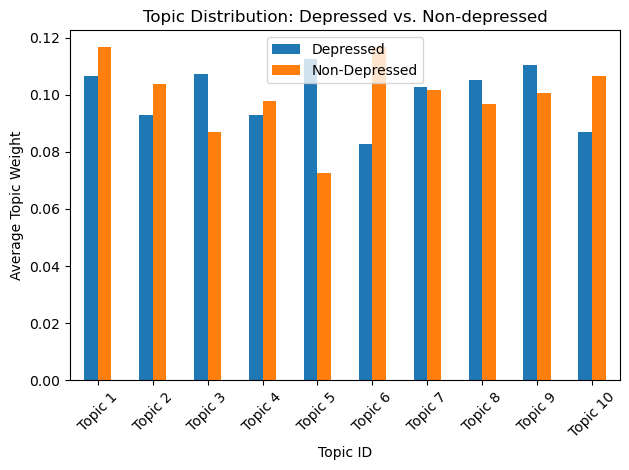

In [43]:
# Slice the LDA output based on the labels.
depressed_tweets = lda_output[df['label'] == 1]
non_depressed_tweets = lda_output[df['label'] == 0]

# Get average topic distribution for each group.
depressed_topic_dist = depressed_tweets.mean(axis=0)
non_depressed_topic_dist = non_depressed_tweets.mean(axis=0)

# Create a DataFrame for plotting.
topic_comparison = pd.DataFrame({
    'Depressed': depressed_topic_dist,
    'Non-Depressed': non_depressed_topic_dist
})

# Plot the comparison.
plt.figure(figsize=(12, 8))
topic_comparison.plot(kind='bar')
plt.title('Topic Distribution: Depressed vs. Non-depressed')
plt.xlabel('Topic ID')
plt.ylabel('Average Topic Weight')
plt.xticks(range(n_topics), [f'Topic {i+1}' for i in range(n_topics)], rotation=45)
plt.tight_layout()
plt.show()